# Getting Started - GPU not CPU

## TensorFlow Flower Classification Example

<p>TensorFlow 2.0 is a library that provides a comprehensive ecosystem of tools for developers, researchers, and organizations who want to build scalable Machine Learning and Deep Learning applications.</p>
<p>Keras is a high-level neural network library that runs on top of TensorFlow. Both provide high-level APIs used for easily building and training models</p>

Import TensorFlow and other necessary libraries:

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from datetime import datetime

First lets check to see if it recognises any specific graphics card...

In [20]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

## Load the Data

**This uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per classicafion:**

flower_photo/
<ul>
<li>daisy/</li>
<li>dandelion/</li>
<li>roses/</li>
<li>sunflowers/</li>
<li>tulips/</li>
</ul>

In [21]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


**Lets show an example...**

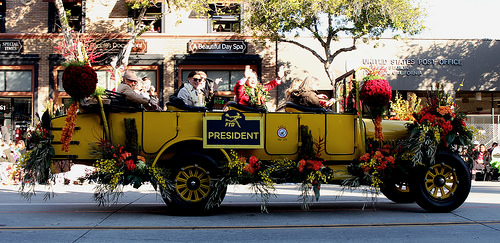

In [22]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

**Now the data has loaded, lets start the clock!**

In [23]:
start_time = datetime.now()

## Build the Training and Validation Data Sets

**Sticking to the usual 80/20 rule for training versus validation**

**The batch size is the number of samples processed before the model is updated. Also, images size is normalised and kept as small as possible.**

In [24]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [25]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [26]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


**AUTOTUNE dynamically evaluates and sets the number of elements to prefetch**

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

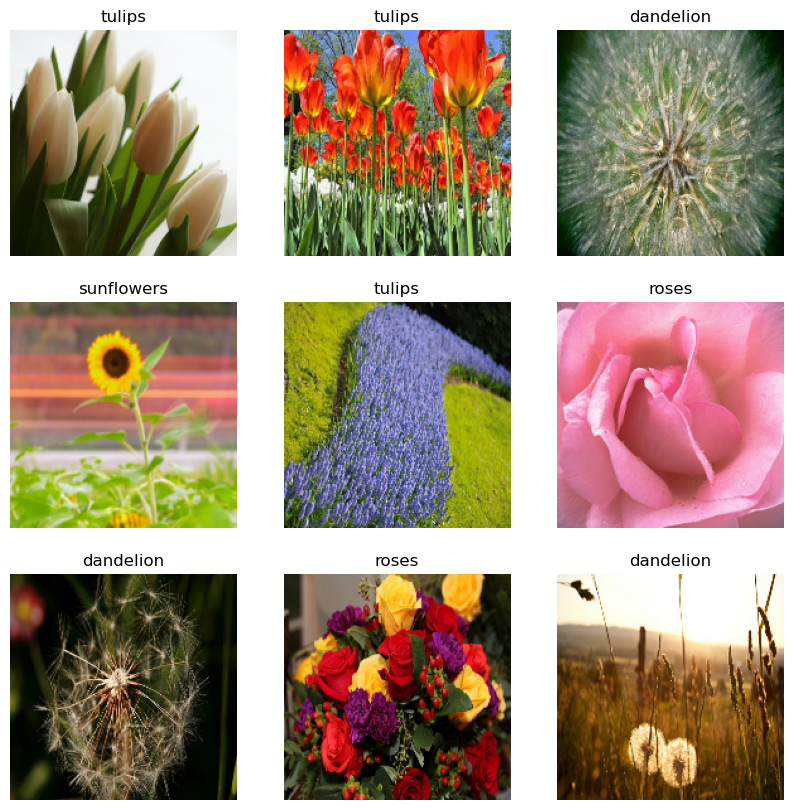

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [29]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Build and Train the Keras Model

Using a Sequential model as each layer has exactly one input tensor and one output tensor.

In [30]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compile the model... Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.**

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Define the number of epochs... an epoch is one entire interation of the training data through the algorithm**
<p>This is what can take the time... </p>

In [32]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 2s 23ms/step - loss: 1.2773 - accuracy: 0.4578 - val_loss: 1.0719 - val_accuracy: 0.5640
Epoch 2/10
92/92 [==============================] - 2s 21ms/step - loss: 0.9499 - accuracy: 0.6362 - val_loss: 0.9008 - val_accuracy: 0.6512
Epoch 3/10
92/92 [==============================] - 2s 21ms/step - loss: 0.7532 - accuracy: 0.7142 - val_loss: 0.8958 - val_accuracy: 0.6403
Epoch 4/10
92/92 [==============================] - 2s 21ms/step - loss: 0.5694 - accuracy: 0.7813 - val_loss: 0.8875 - val_accuracy: 0.6526
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.3341 - accuracy: 0.8856 - val_loss: 1.0033 - val_accuracy: 0.6322
Epoch 6/10
92/92 [==============================] - 2s 21ms/step - loss: 0.1838 - accuracy: 0.9407 - val_loss: 1.2012 - val_accuracy: 0.6322
Epoch 7/10
92/92 [==============================] - 2s 20ms/step - loss: 0.0986 - accuracy: 0.9714 - val_loss: 1.3794 - val_accuracy: 0.6417
Epoch 8/10
92

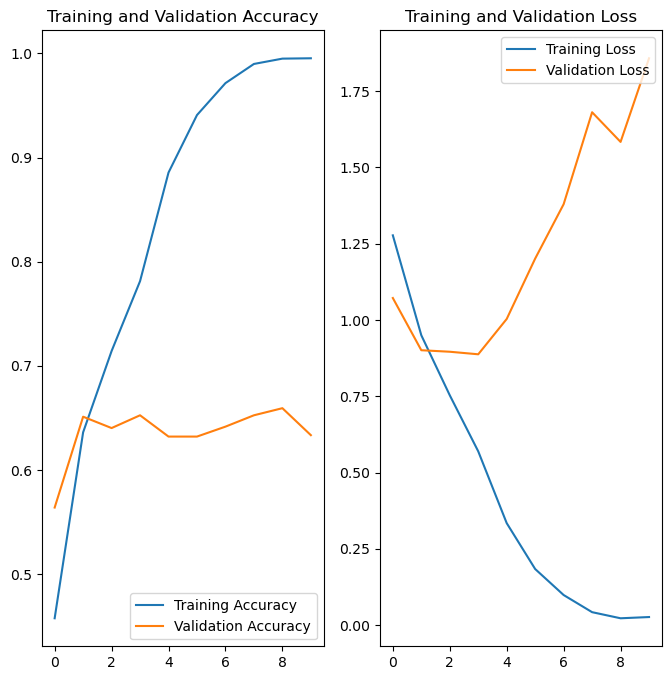

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test the model

Load up an image and pass through the model...

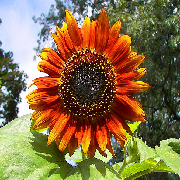

In [34]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
display(img)

In [35]:


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 56ms/step
This image most likely belongs to sunflowers with a 77.02 percent confidence.


In [36]:
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Time elapsed (hh:mm:ss.ms) 0:00:20.878624
